**Please don't edit this cell!**

# Marks and Feedback

**Total Marks:**   XX/100

**Overall comments:**


## Part 1. Investigations into Neural Networks (35 marks)

* **Task 1**:   *Experiments with learning rate schedules* - XX/5
    * learning rate schedulers implemented
    * experiments carried out
    * further comments


* **Task 2**:   *Experiments with regularisation* - XX/5
    * L1 experiments
    * L2 experiments
    * dropout experiments
    * annealed dropout implmented
    * further experiments carried out
    * further comments
    

* **Task 3**:   *Experiments with pretraining* - XX/15
    * autoencoder pretraining implemented
    * denoising autoencoder pretraining implemented
    * CE layer-by-layer pretraining implemented
    * experiments
    * further comments


* **Task 4**:   *Experiments with data augmentation* - XX/5
    * training data augmneted using noise, rotation, ...
    * any further augmnetations
    * experiments 
    * further comments


* **Task 5**:   *State of the art* - XX/5
    * motivation for systems constructed
    * experiments
    * accuracy of best system
    * further comments



## Part 2. Convolutional Neural Networks (55 marks)

* **Task 6**:   *Implement convolutional layer* - XX/20
    * linear conv layer
    * sigmoid conv layer
    * relu conv layer
    * any checks for correctness
    * loop-based or vectorised implementations
    * timing comparisons


* **Task 7**:   *Implement maxpooling layer* - XX/10
    * implementation of non-overlapping pooling
    * generic implementation
    * any checks for correctness


* **Task 8**:   *Experiments with convolutional networks* - XX/25
    * 1 conv layer (1 fmap)
    * 1 conv layer (5 fmaps)
    * 2 conv layers
    * further experiments



## Presentation (10 marks)

* ** Marks:**   XX/10
    * Concise description of each system constructed
    * Experiment design and motivations for different systems
    * Presentation of results - graphs, tables, diagrams
    * Conclusions



# Coursework #2

## Introduction


## Previous Tutorials

Before starting this coursework make sure that you have completed the following labs:

* [04_Regularisation.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/04_Regularisation.ipynb) - regularising the model
* [05_Transfer_functions.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/05_Transfer_functions.ipynb) - building and training different activation functions
* [06_MLP_Coursework2_Introduction.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/06_MLP_Coursework2_Introduction.ipynb) - Notes on numpy and tensors


## Submission
**Submission Deadline:  Thursday 14 January 2016, 16:00** 

Submit the coursework as an ipython notebook file, using the `submit` command in the terminal on a DICE machine. If your file is `06_MLP_Coursework1.ipynb` then you would enter:

`submit mlp 2 06_MLP_Coursework1.ipynb` 

where `mlp 2` indicates this is the second coursework of MLP.

After submitting, you should receive an email of acknowledgment from the system confirming that your submission has been received successfully. Keep the email as evidence of your coursework submission.

**Please make sure you submit a single `ipynb` file (and nothing else)!**

**Submission Deadline:  Thursday 14 January 2016, 16:00** 



## Getting Started
Please enter your student number and the date in the next code cell.

In [ ]:
#MLP Coursework 2
#Student number: <ENTER STUDENT NUMBER>
#Date: <ENTER DATE>

In [14]:
import numpy

#Seed a random number generator running the below cell, but do **not** modify the seed.
rng = numpy.random.RandomState([2015,10,10])
rng_state = rng.get_state()

import logging
import time
import matplotlib.pyplot as plt

from mlp.costs import MSECost, CECost  # import the cost we want to use for optimisation
from mlp.dataset import MNISTDataProvider  # import data provider
from mlp.layers import MLP, Sigmoid, Softmax, Linear  # import required layer types
from mlp.optimisers import SGDOptimiser, AutoEncoder, CrossEntropy, DenoisingAutoEncoder  # import the optimiser
from mlp.schedulers import LearningRateFixed, LearningRateNewBob, DropoutFixed, DropoutAnnealing, LearningRateExp, LearningRateRecip
from mlp.noise import NoiseMaker, DropoutNoise, RotationNoise
from mlp.dataset import add_batches
from mlp.conv import ConvLinear, ConvSigmoid, ConvRelu, ConvMaxPool2D

logger = logging.getLogger()
logger.warning('Initialising data providers...')
train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=-10, randomize=False)

class Result(object):
    """ A convenience object for recording results of a model """
    def __init__(self, title):
        self.title = title
        self.train_errors_matrix = []
        self.valid_errors_matrix = []
        self.test_errors = []
        
    def add_train(self, train_stats):
        train_errors = [10.0 * (1-train_stat[1]) for train_stat in train_stats]
        self.train_errors_matrix.append(train_errors)
        
    def add_valid(self, valid_stats):
        valid_errors = [10.0 * (1-valid_stat[1]) for valid_stat in valid_stats]
        self.valid_errors_matrix.append(valid_errors)
        
    def add_test(self, tst_accuracy):
        self.test_errors.append(1-tst_accuracy)
        
    def add_results(self, train_stats, valid_stats, tst_accuracy):
        self.add_train(train_stats)
        self.add_valid(valid_stats)
        self.add_test(tst_accuracy)
        
    def draw(self, iteration_name, rows, cols, figsize, train_y_lim=None, valid_y_lim=None):
        fig, axis_array = plt.subplots(rows, cols, figsize=figsize)

        for i, train_errors in enumerate(self.train_errors_matrix):
            axis_array[0].plot(train_errors, label='{0} {1} ({2} epochs)'.format(
                    iteration_name, str(i), len(train_errors)))

        for i, valid_errors in enumerate(self.valid_errors_matrix):
            axis_array[1].plot(valid_errors, label='{0} {1} ({2} epochs)'.format(
                    iteration_name, str(i), len(valid_errors)))

        # show to line graphs using the training and validation results
        axis_array[0].set_title("T - {0}".format(self.title))
        axis_array[0].set_xlabel('epoch')
        axis_array[0].set_ylabel('training error')  
        axis_array[0].legend()
        axis_array[0].grid()
        if train_y_lim:
            axis_array[0].set_ylim(0, train_y_lim)

        axis_array[1].set_title("V - {0}".format(self.title))
        axis_array[1].set_xlabel('epoch')
        axis_array[1].set_ylabel('validation error')
        axis_array[1].legend()
        axis_array[1].grid()
        if valid_y_lim:
            axis_array[1].set_ylim(0, valid_y_lim)
            
        plt.show()
        
def reset_data():
    train_dp.reset()
    valid_dp.reset()
    test_dp.reset()

# Part 1. Investigations into Neural Networks (35 marks)

In this part you are may choose exactly what you implement. However, you are expected to express your motivations, observations, and findings in a clear and cohesive way. Try to make it clear why you decided to do certain things. Use graphs and/or tables of results to show trends and other characteristics you think are important. 

For example, in Task 1 you could experiment with different schedulers in order to compare their convergence properties. In Task 2 you could look into (and visualise) what happens to weights when applying L1 and/or L2 regularisation when training. For instance, you could create sorted histograms of weight magnitudes in in each layer, etc..

**Before submission, please collapse all the log entries into smaller boxes (by clicking on the bar on the left hand side)**

### Task 1 - Experiments with learning rate schedules (5 marks)

Investigate the effect of learning rate schedules on training and accuracy.  Implement at least one additional learning rate scheduler mentioned in the lectures. 

In [ ]:
# %load -s LearningRateExp,LearningRateRecip mlp/schedulers.py
class LearningRateExp(LearningRateList):
    def __init__(self, learning_rate, max_epochs, rate):
        assert learning_rate > 0, (
            "learning rate expected to be > 0, got %f" % learning_rate
        )
        self.rate = rate
        super(LearningRateExp, self).__init__([learning_rate], max_epochs)

    def get_rate(self):
        if self.epoch < self.max_epochs:
            return self.lr_list[0] * np.exp(-float(self.epoch)/float(self.rate))
        return 0.0

    def get_next_rate(self, current_accuracy=None):
        super(LearningRateExp, self).get_next_rate(current_accuracy=None)
        return self.get_rate()

class LearningRateRecip(LearningRateList):
    def __init__(self, learning_rate, max_epochs, rate, c):
        assert learning_rate > 0, (
            "learning rate expected to be > 0, got %f" % learning_rate
        )
        self.rate = rate
        self.c = c
        super(LearningRateRecip, self).__init__([learning_rate], max_epochs)

    def get_rate(self):
        if self.epoch < self.max_epochs:
            return self.lr_list[0] * np.power(1.0+(float(self.epoch)/float(self.rate)), -float(self.c))
        return 0.0

    def get_next_rate(self, current_accuracy=None):
        super(LearningRateRecip, self).get_next_rate(current_accuracy=None)
        return self.get_rate()


#### EXPERIMENT
For this experiment I decided to compare the effect of the value of r on the exponential and reciprocal learning rate shedulers. To do this, I put them side by side with the fixed and new bob learing rate shedulers.

In [5]:
#load the corresponding code here, and also attach scripts that run the experiments ()
%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# some hyper-parameters
nhid = 100
max_epochs = 10
cost = CECost()
num_layers = 1
rate_list = [1.0, 5.0, 10.0, 20.0]

results_set = []

for rate in rate_list:
    # make a list of the Schedulers
    s1 = LearningRateFixed(learning_rate=0.1, max_epochs=max_epochs), "Fixed"
    s2 = LearningRateNewBob(start_rate=0.1, max_epochs=max_epochs), "NewBob"
    s3 = LearningRateExp(learning_rate=2.0, max_epochs=max_epochs, rate=rate), "Exponential"
    s4 = LearningRateRecip(learning_rate=2.0, max_epochs=max_epochs, rate=rate, c=1.0), "Reciprocal"
    schedulers = [s1, s2, s3, s4]
    
    results = Result("Schedulers rate {0}".format(rate)) 
    for scheduler, title in schedulers:
        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        # define the model structure
        model = MLP(cost=cost)
        model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))
        for i in xrange(1, num_layers):
            logger.info("Stacking hidden layer (%s)" % str(i+1))
            model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))
        model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

        # define the optimiser, here stochasitc gradient descent
        optimiser = SGDOptimiser(lr_scheduler=scheduler)

        logger.info('Training started...')
        train_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set...')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.warning('MNIST test set accuracy is %.2f %% (cost is %.3f)' % (tst_accuracy * 100., tst_cost))

        results.add_results(train_stats, valid_stats, tst_accuracy)
    results_set.append(results)

#### RESULTS
The results on the graph show the classification accuracy on the test set per epoch up to 10 epochs.
We can see that exponential and reciprocal converge faster since the learing rate for the first few epoch is higher.
We can also expect to achive a higher classification accuracy by the end of the training sice the smaller learning rates allow the model to be more finely tuned.

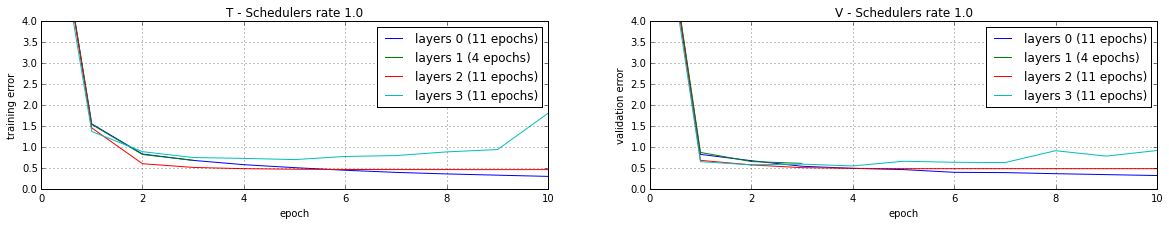

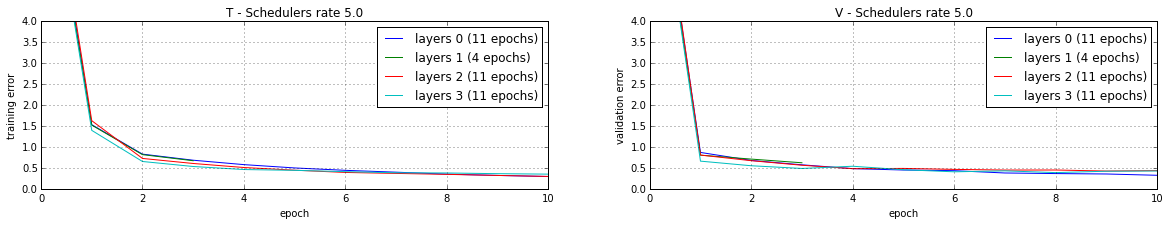

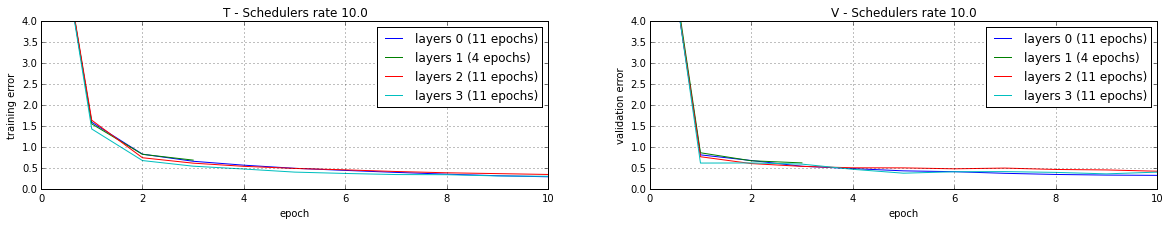

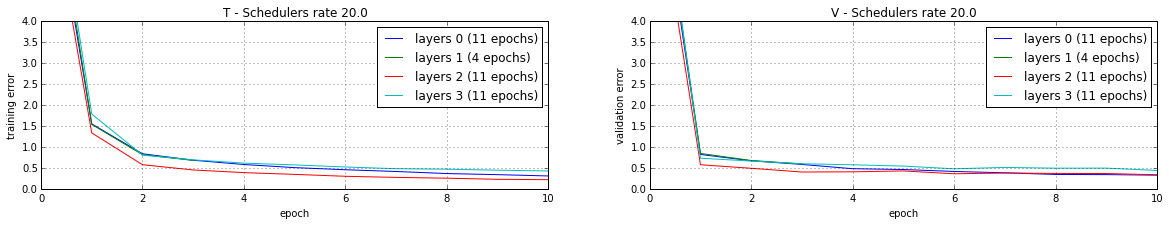

In [6]:
%matplotlib inline
for results in results_set:
    results.draw("layers", 1, 2, figsize=(20, 3), train_y_lim=4, valid_y_lim=4)

### Task 2 - Experiments with regularisers (5 marks)

Investigate the effect of different regularisation approaches (L1, L2, dropout).  Implement the annealing dropout scheduler (mentioned in lecture 5). Do some further investigations and experiments with model structures (and regularisers) of your choice. 

In [ ]:
# %load -s DropoutAnnealing mlp/schedulers.py
class DropoutAnnealing(LearningRateList):
    def __init__(self, p_inp_keep, p_hid_keep, decay):
        """
        Dropout rate schedule starting with a fraction p units dropped, decreasing at a constant rate to 0
        :param p_inp_keep: the initial percentage of input units to keep
        :param p_hid_keep: the initial percentage of hidden units to keep
        :param decay: the rate of decay of kept units (decay to 1)
        :return:
        """
        assert 0 < p_inp_keep <= 1 and 0 < p_hid_keep <= 1, (
            "Dropout 'keep' probabilites are suppose to be in (0, 1] range"
        )
        self.decay = decay
        self.p_inp_keep = p_inp_keep
        self.p_hid_keep = p_hid_keep
        self.epoch = 0
        super(DropoutAnnealing, self).__init__([(p_inp_keep, p_hid_keep)], max_epochs=999)

    def get_rate(self):
        return self.lr_list[0]

    def get_next_rate(self, current_accuracy=None):
        # increase the percentage of units kept
        p_inp, p_hid = self.get_rate()
        self.epoch += 1
        self.lr_list[0] = min(p_inp+self.decay, 1), min(p_hid+self.decay, 1)
        logger = logging.getLogger()
        if p_inp != 1 and self.lr_list[0][0] == 1:
            logger.warning('Input Dropout stopped after {} epochs'.format(self.epoch))
        if p_hid != 1 and self.lr_list[0][1] == 1:
            logger.warning('Hidden Dropout stopped after {} epochs'.format(self.epoch))
        # logger.warning('Input Dropout decayed to {0}'.format(p_inp))
        # logger.warning('Hidden Dropout decayed to {0}'.format(p_hid))
        return p_inp, p_hid


#### EXPERIMENT
This experiment tests the effect of L1 and L2 regularisation on the 
classification accuracy

I expect that dropout will basically add more training examples implicitly within the model
which could increase test accuracy (especially on small data sets) but might require more epochs to converge

In [32]:
%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# some hyper-parameters
nhid = 50
learning_rate = 0.5
max_epochs = 10
cost = CECost()
num_layers = 0

# make a list of the regularisers
l1_l2_weights = [
    (0.0, 0.0, "None"),
    (0.1, 0.0, "L1"),
    (0.0, 0.1, "L2"),
    (0.1, 0.1, "L1 and L2")
]

results = Result("L1 and L2 Regularisation")
weights = []

for l1_weight, l2_weight, title in l1_l2_weights:
    reset_data()
    # define the model structure
    model = MLP(cost=cost)
    model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))
    for i in xrange(1, num_layers):
        logger.info("Stacking hidden layer (%s)" % str(i+1))
        model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))
    model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

    # define the optimiser, here stochasitc gradient descent
    lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=None,
                             l1_weight=l1_weight, 
                             l2_weight=l2_weight)

    logger.info('Training started...')
    train_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

    logger.info('Testing the model on test set...')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.warning('MNIST test set accuracy is %.2f %% (cost is %.3f)' % (tst_accuracy * 100., tst_cost))

    weights.append((model.layers[0].W, model.layers[1].W))
    results.add_results(train_stats, valid_stats, tst_accuracy)

#### RESULTS
The l1 and l2 regulisation tends make the model prefer smaller weights.
We can see from the diagrams that 1l force all weights very close to 0, whereas l2 weights casue more of a bell shape of weights close to zero. The regularisation techniques will be useful in making sure that the model does not become overfit to the training set.

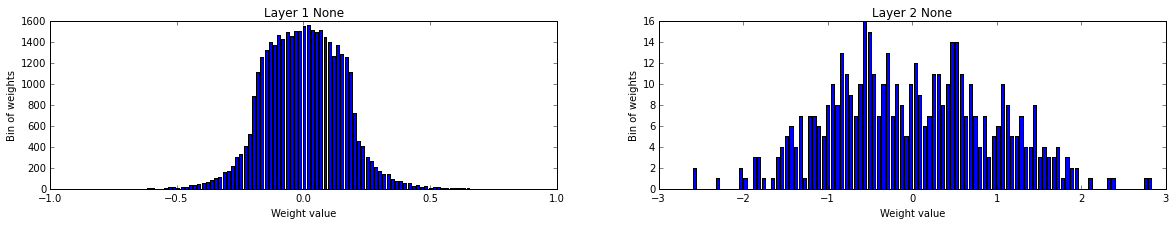

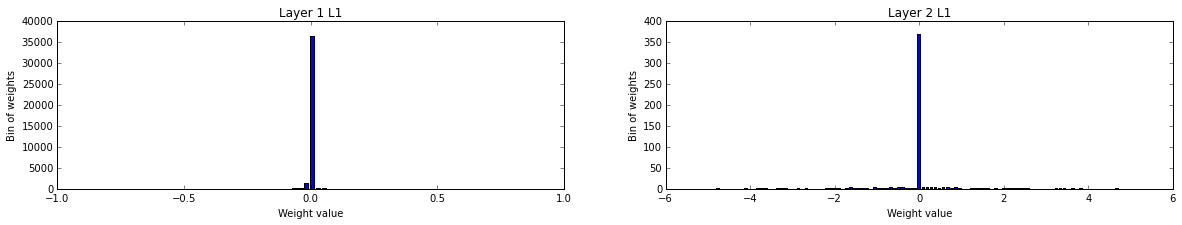

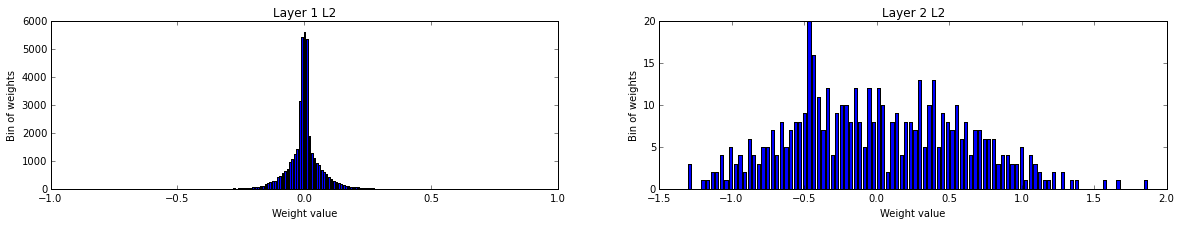

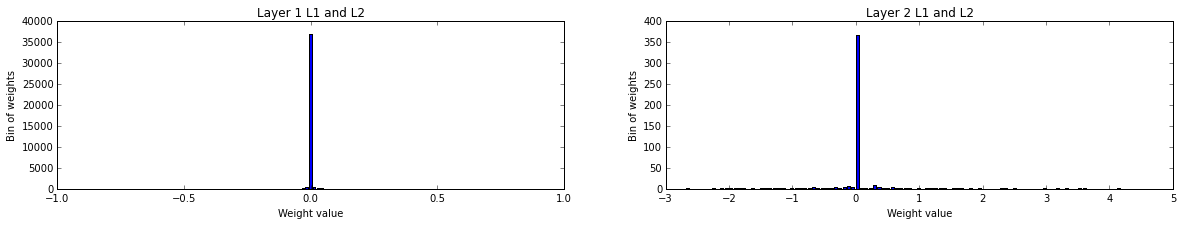

In [33]:
for i in xrange(len(weights)):
    fig, axis_array = plt.subplots(1, 2, figsize=(20, 3))

    w1, w2 = weights[i]
    _, _, title = l1_l2_weights[i]

    # show to line graphs using the training and validation results
    hist, bins = numpy.histogram(w1.T, bins=100)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    axis_array[0].bar(center, hist, align='center', width=width)
    axis_array[0].set_title("{0} {1}".format("Layer 1", title))
    axis_array[0].set_xlim(-1, 1)
    axis_array[0].set_xlabel('Weight value')
    axis_array[0].set_ylabel('Bin of weights')


    hist, bins = numpy.histogram(w2, bins=100)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    axis_array[1].bar(center, hist, align='center', width=width)
    axis_array[1].set_title("{0} {1}".format("Layer 2", title))
    axis_array[1].set_xlabel('Weight value')
    axis_array[1].set_ylabel('Bin of weights')

plt.show()

### EXPERIMENT
This experiment tests the effect of the dropout rate of dropout decay regulariser on the classification accuracy of the test set.

In [2]:
%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# some hyper-parameters
nhid = 50
learning_rate = 0.5
max_epochs = 10
cost = CECost()
num_layers = 0

# make a list of the regularisers
l1_l2_weights = [
    (0.0, 0.0, None, "None"),
#     (0.0001, 0.0, None, "L1"),
#     (0.0, 0.0001, None, "L2"),
    (0.0, 0.0, DropoutFixed(0.5, 0.5), "DropoutFixed"),
    (0.0, 0.0, DropoutAnnealing(0.5, 0.5, 0.03), "DropoutAnnealing rate 0.03"),
    (0.0, 0.0, DropoutAnnealing(0.5, 0.5, 0.05), "DropoutAnnealing rate 0.05"),
    (0.0, 0.0, DropoutAnnealing(0.5, 0.5, 0.07), "DropoutAnnealing rate 0.07"),
    (0.0, 0.0, DropoutAnnealing(0.5, 0.5, 0.09), "DropoutAnnealing rate 0.09"),
    (0.0, 0.0, DropoutAnnealing(0.5, 0.5, 0.11), "DropoutAnnealing rate 0.11"),
    (0.0, 0.0, DropoutAnnealing(0.5, 0.5, 0.13), "DropoutAnnealing rate 0.13"),
]


results = Result("Dropout Regularisation")
for l1_weight, l2_weight, dp_scheduler, title in l1_l2_weights:
    reset_data()
    # define the model structure
    model = MLP(cost=cost)
    model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))
    for i in xrange(1, num_layers):
        logger.info("Stacking hidden layer (%s)" % str(i+1))
        model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))
    model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

    # define the optimiser, here stochasitc gradient descent
    lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=dp_scheduler,
                             l1_weight=l1_weight, 
                             l2_weight=l2_weight)

    logger.info('Training started...')
    train_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

    logger.info('Testing the model on test set...')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.warning('MNIST test set accuracy is %.2f %% (cost is %.3f)' % (tst_accuracy * 100., tst_cost))

    results.add_results(train_stats, valid_stats, tst_accuracy)

#### RESULTS
It seems the best classification accuracy comes from a dropout annealing with these configurations
 - DropoutAnnealing(0.5, 0.5, 0.05)
 
Stoping decay after 10 epochs giving it just 1 epoch to fine tune.

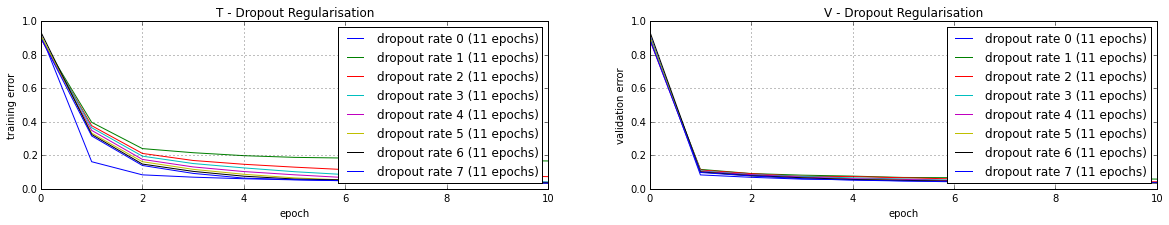

In [6]:
%matplotlib inline
results.draw("dropout rate", 1, 2, figsize=(20, 3))

### Task 3 - Experiments with pretraining (15 marks)

Implement pretraining of multi-layer networks with autoencoders, denoising autoencoders, and using  layer-by-layer cross-entropy training.  

Implementation tip: You could add the corresponding methods to `optimiser`, namely, `pretrain()` and `pretrain_epoch()`, for autoencoders. Simiilarly, `pretrain_discriminative()` and `pretrain_epoch_discriminative()` for cross-entropy layer-by-layer pretraining. Of course, you can modify any other necessary pieces, but include all the modified fragments below.

In [ ]:
%load -s AutoEncoder,CrossEntropy,DenoisingAutoEncoder mlp/optimisers.py

In [5]:
def get_unit_count(layer_count, nhid_for_1_layer):
    """
    For a given layer count, calculates the number of units per layer
    such that the total number of weights remains the same
    b = layer_count
    (784 * x) + ((b-1)*(x**2)) + (x * 10) = 635200
    ((b-1)*(x**2)) + (794 * x) - 635200 = 0
    """
    if layer_count == 0:
        raise NotImplemented("Can calculate for 0 hidden layers")
    else :
        if layer_count == 1:
            return nhid_for_1_layer
        else:
            return (-794 + numpy.sqrt(794**2 - 4*(layer_count-1)*(-(nhid_for_1_layer*794)))) / (2 * (layer_count-1))

#### EXPERIMENT
 Explore the effect the effect of:
 - None vs AutoEncoder vs CrossEntropy vs DenoisingAutoEncoder
 - pre training learning rate
 - number of layers
 
on the  classification accuracy.
To make the test fair, each model will have the same number of trainable 
weights despite the number of layers.

Since AutoEncoder and CrossEntropy are designed to help train deep networks 
I would predict that they should perform better on deeper neural nets

In [8]:
%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# some hyper-parameters
nhid_for_1_layer = 100
learning_rate = 0.5
max_epochs = 10
pre_max_epochs = 5
cost = CECost()
num_layers_list = [1, 2, 5, 10]

noise = DropoutNoise(0.5)

# make a list of the Pre Trainers
p0 = None, "None"
p1 = AutoEncoder(learning_rate=0.01, max_epochs=10), "AutoEncoder, lr=0.01"
p2 = AutoEncoder(learning_rate=0.05, max_epochs=10), "AutoEncoder, lr=0.05"
p3 = AutoEncoder(learning_rate=0.5, max_epochs=10), "AutoEncoder, lr=0.5"
p4 = AutoEncoder(learning_rate=1.0, max_epochs=10), "AutoEncoder, lr=1.0"
p5 = CrossEntropy(learning_rate=0.01, max_epochs=pre_max_epochs), "CrossEntropy, lr=0.01"
p6 = CrossEntropy(learning_rate=0.5, max_epochs=pre_max_epochs), "CrossEntropy, lr=0.5"
p7 = CrossEntropy(learning_rate=1.0, max_epochs=pre_max_epochs), "CrossEntropy, lr=1.0"
p8 = CrossEntropy(learning_rate=2.0, max_epochs=pre_max_epochs), "CrossEntropy, lr=2.0"
p9 = DenoisingAutoEncoder(learning_rate=0.01, max_epochs=10, noise=noise, rng=rng), "DenoisingAutoEncoder, lr=0.01"
p10 = DenoisingAutoEncoder(learning_rate=0.05, max_epochs=10, noise=noise, rng=rng), "DenoisingAutoEncoder, lr=0.05"
p11 = DenoisingAutoEncoder(learning_rate=0.5, max_epochs=10, noise=noise, rng=rng), "DenoisingAutoEncoder, lr=0.5"
p12 = DenoisingAutoEncoder(learning_rate=1.0, max_epochs=10, noise=noise, rng=rng), "DenoisingAutoEncoder, lr=1.0"
pre_trainers = [p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12]

results_set = []

for pre_trainer, title in pre_trainers:
    results = Result(title)
    for num_layers in num_layers_list:
        # find the unit count such that the number of weights are the same as that of 1 hidden layer
        nhid = int(get_unit_count(num_layers, nhid_for_1_layer))
        logger.warning("Calculated hidden layer size of %s units" % str(int(nhid)))
        # define the model structure
        model = MLP(cost=cost)
        model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))
        for i in xrange(1, num_layers):
            logger.info("Stacking hidden layer (%s)" % str(i+1))
            model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))
        model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

        start = time.clock()
        reset_data()
        if pre_trainer:
            logger.info('Pre Training started...')
            pre_trainer.pretrain(model, train_iter=train_dp)
        reset_data()

        lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=None,
                                 l1_weight=0.0, 
                                 l2_weight=0.0)

        logger.info('Training started...')
        train_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)
        stop = time.clock()
        
        logger.info('Testing the model on test set...')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.warning('MNIST test set accuracy is %.2f %% (cost is %.3f) in %.0f seconds' 
                       % (tst_accuracy * 100., tst_cost, stop - start))

        results.add_results(train_stats, valid_stats, tst_accuracy)
    results_set.append(results)

#### RESULTS
 - The non pretrained model could not handle models with more than 5 layers.
 - The autoencoders work well on models where the number of layers was less than 5.
 - The CrossEntropy can work on a model of any depth however require more computational time than auto encoders.

The pretraing method which yeilds the greatest classification accuracy is CrossEntropy with a pre training learning rate of 2.0 since this can quickly improve the model in the 5 pre training epochs.

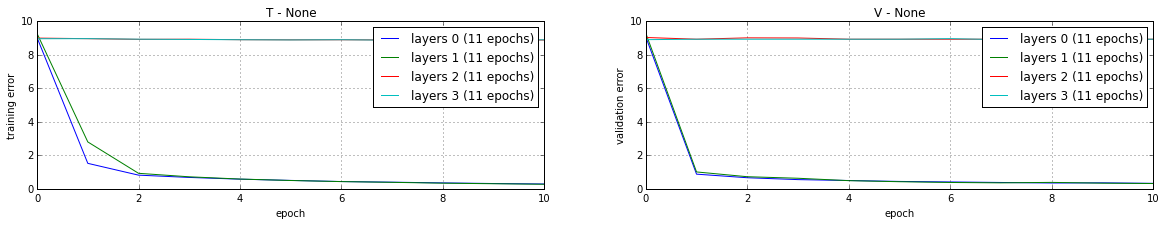

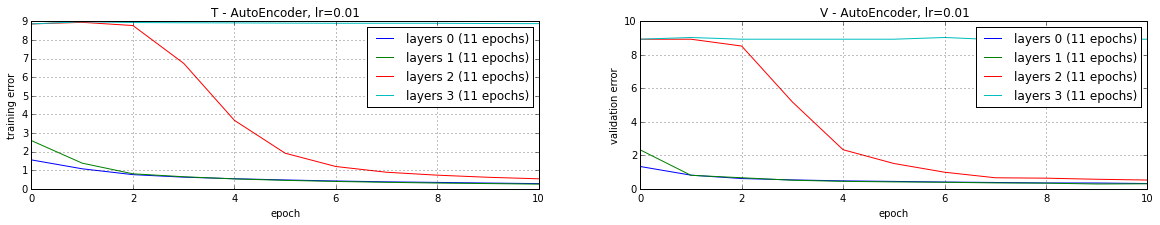

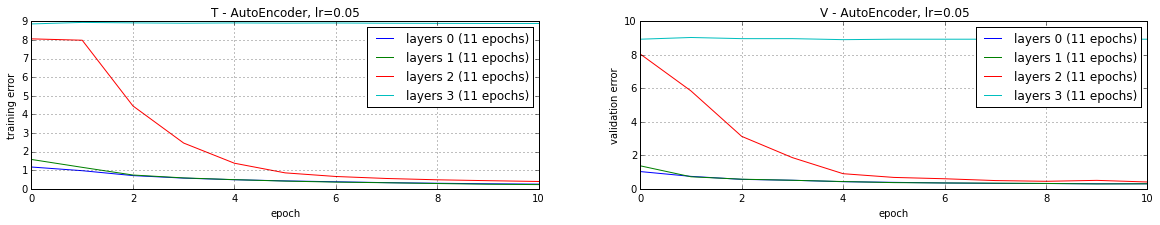

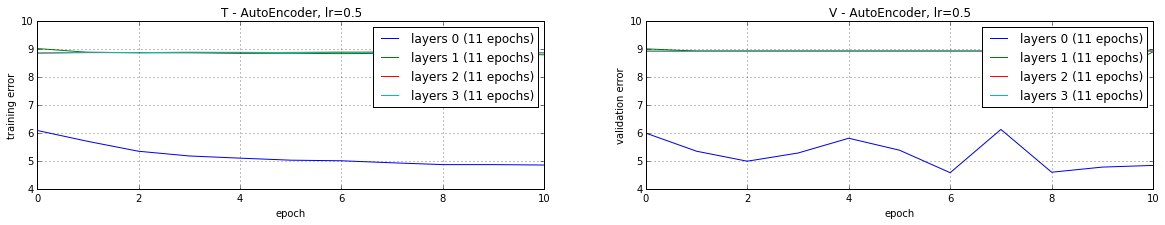

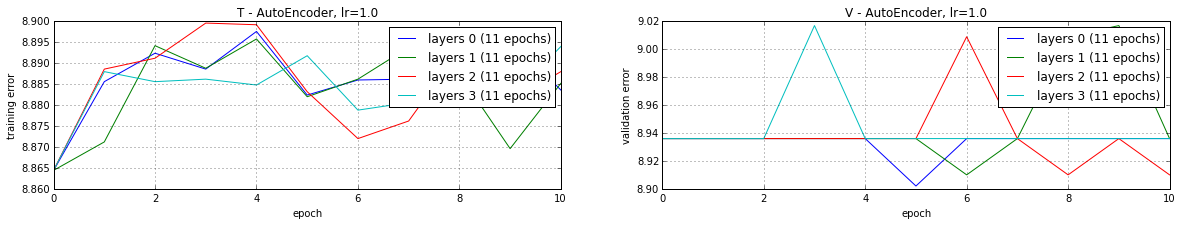

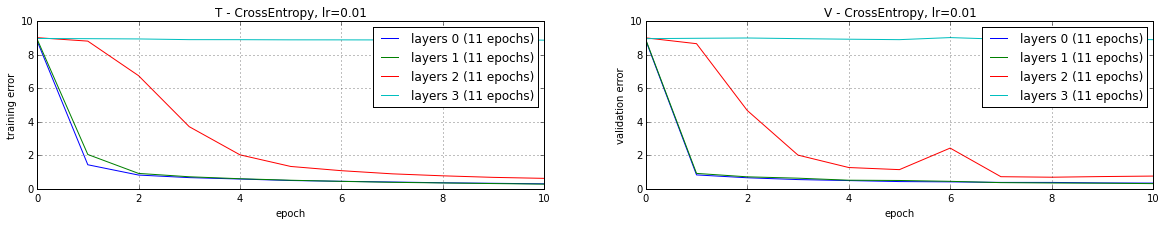

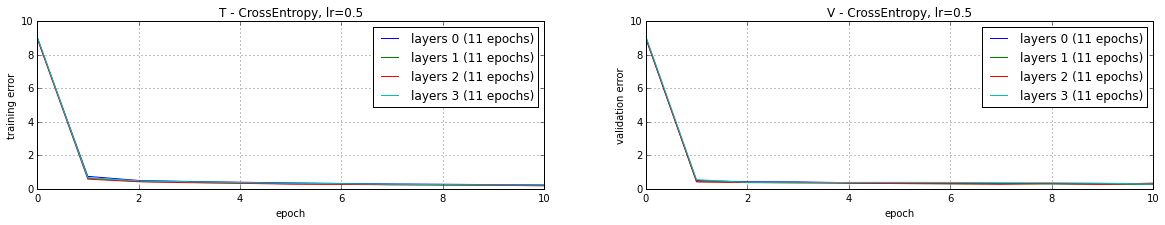

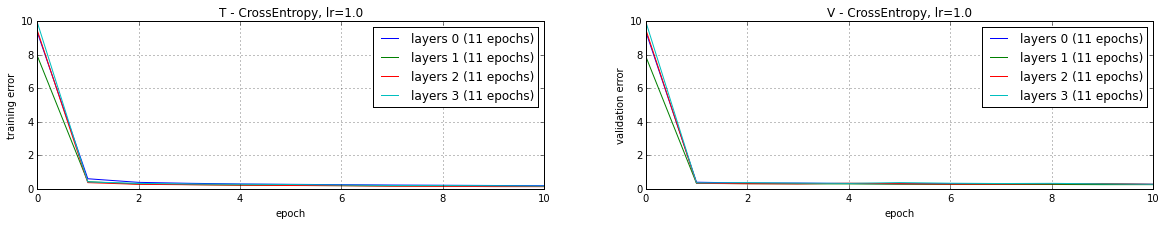

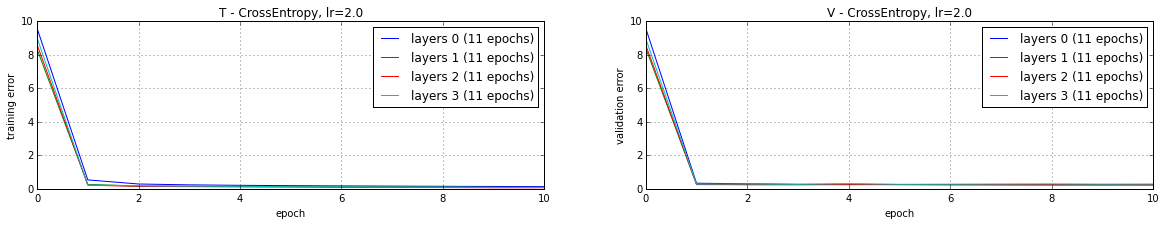

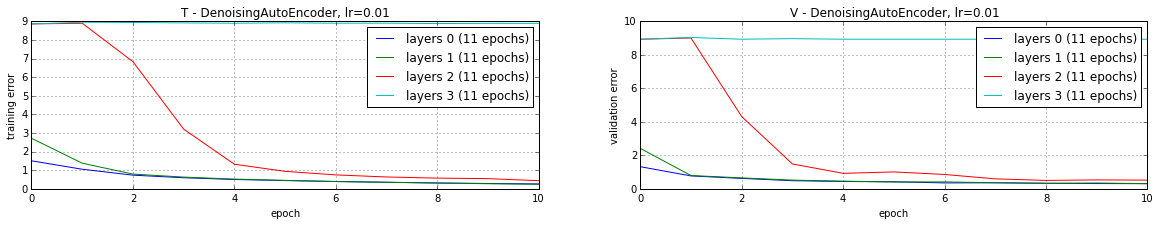

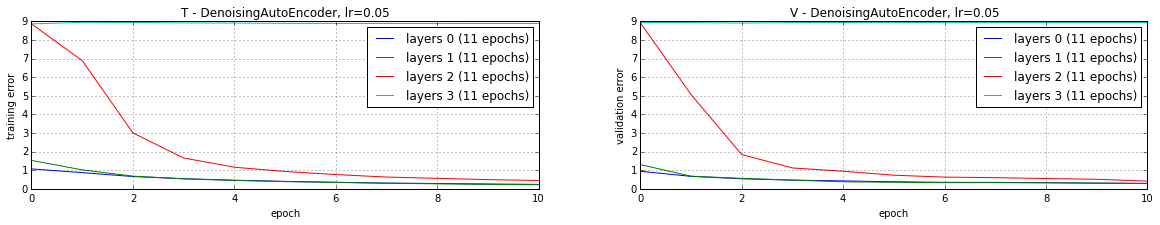

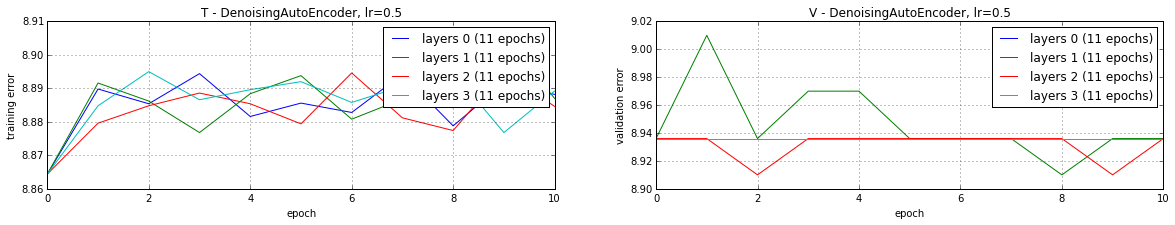

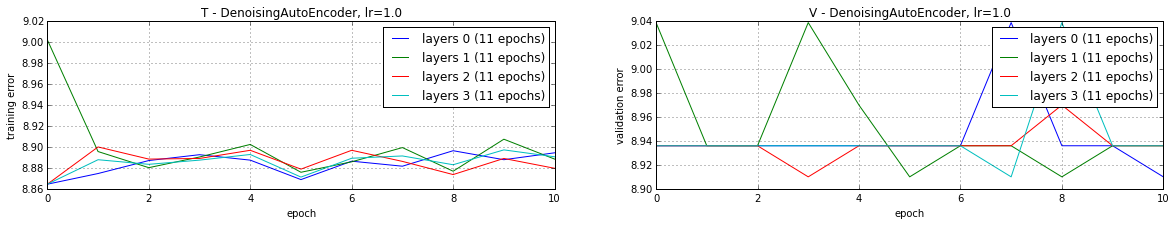

In [9]:
%matplotlib inline
for results in results_set:
    results.draw("layers", 1, 2, figsize=(20, 3))

### Task 4 - Experiments with data augmentation (5 marks)

Using the standard MNIST training data, generate some augmented training examples (for example, using noise or rotation). Perform experiments on using this expanded training data.

In [ ]:
%load mlp/noise.py

In [ ]:
%load -s add_batch,add_batches mlp/dataset.py

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


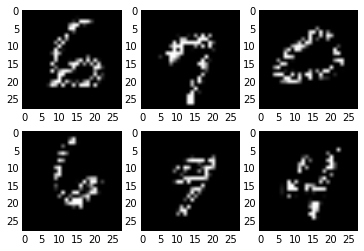

In [8]:
%pylab
%matplotlib inline

logger = logging.getLogger()
logger.warning('Initialising data providers...')
train_dp_aug = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)
train_dp_aug.reset()

noise_type = DropoutNoise(dropout_prob=0.5)
noise_maker = NoiseMaker(data_set=train_dp_aug, num_batches=10, noise=noise_type)  
new_batches = noise_maker.make_examples(rng=rng)
add_batches(train_dp_aug, new_batches)

imgs_raw, digits = new_batches[0]

imgs = [img.reshape(28,28) for img in imgs_raw[:10]]

fig, ax = plt.subplots(2,3)
ax[0, 0].imshow(imgs[0], cmap=cm.Greys_r)
ax[0, 1].imshow(imgs[1], cmap=cm.Greys_r)
ax[0, 2].imshow(imgs[2], cmap=cm.Greys_r)
ax[1, 0].imshow(imgs[3], cmap=cm.Greys_r)
ax[1, 1].imshow(imgs[4], cmap=cm.Greys_r)
ax[1, 2].imshow(imgs[5], cmap=cm.Greys_r)

#### EXPERIMENT
Compare the effect of dropout noise and rotation noise on different portions of the training data. Compare the difference in test set classification accuracy across these data augmenters.

In [15]:
%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.WARNING)


# some hyper-parameters
nhid = 50
learning_rate = 0.5
max_epochs = 10
cost = CECost()
num_layers = 0

dropout_probs_list = [0.9, 0.7, 0.5, 0.3]

results_list = []

for dropout_prob in dropout_probs_list:
    results = Result("Dropout Prob {}".format(dropout_prob))

    # make a list of the noise makers
    noise_makers = [
        NoiseMaker(data_set=train_dp, num_batches=10, noise=DropoutNoise(dropout_prob=dropout_prob)),
        NoiseMaker(data_set=train_dp, num_batches=100, noise=DropoutNoise(dropout_prob=dropout_prob)),
        NoiseMaker(data_set=train_dp, num_batches=500, noise=DropoutNoise(dropout_prob=dropout_prob)),
        NoiseMaker(data_set=train_dp, num_batches=10, noise=RotationNoise(dropout_prob=dropout_prob)),
        NoiseMaker(data_set=train_dp, num_batches=100, noise=RotationNoise(dropout_prob=dropout_prob)),
        NoiseMaker(data_set=train_dp, num_batches=500, noise=RotationNoise(dropout_prob=dropout_prob)),
    ]

    for noise_maker in noise_makers:
        logger.info('Initialising data providers...')
        train_dp_aug = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)

        logger.warning('Adding noisy examples...')
        new_batches = noise_maker.make_examples(rng=rng)
        add_batches(train_dp_aug, new_batches)
        reset_data()
        train_dp_aug.reset()

        # define the model structure
        model = MLP(cost=cost)
        model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))
        for i in xrange(1, num_layers):
            logger.info("Stacking hidden layer (%s)" % str(i+1))
            model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))
        model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

        # define the optimiser, here stochasitc gradient descent
        lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=None, l1_weight=0.0, l2_weight=0.0)

        logger.info('Training started...')
        train_stats, valid_stats = optimiser.train(model, train_dp_aug, valid_dp)

        logger.info('Testing the model on test set...')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.warning('MNIST test set accuracy is %.2f %% (cost is %.3f)' % (tst_accuracy * 100., tst_cost))

        results.add_results(train_stats, valid_stats, tst_accuracy)
    
    results_list.append(results)

#### RESULTS
The Noise has a negative effect on the classification accuracy when applied to the training set. However this difference is relatively small, only up to 4%. However this could be offset by training for more epochs. 

When there are too few training examplez this shows that the amount of data could be artificailly inceased to give a better performance on the model. Also the data augmentation could act as a regularise and squeeze more performance out of a classify which is over-fitted.


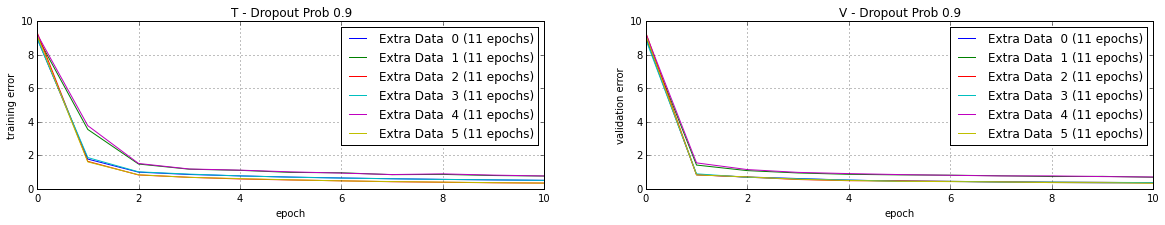

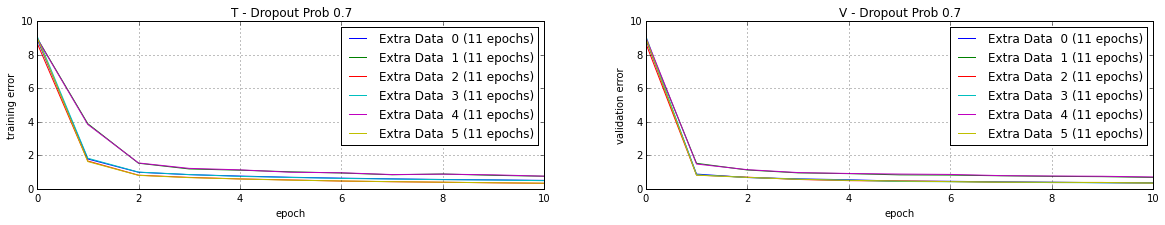

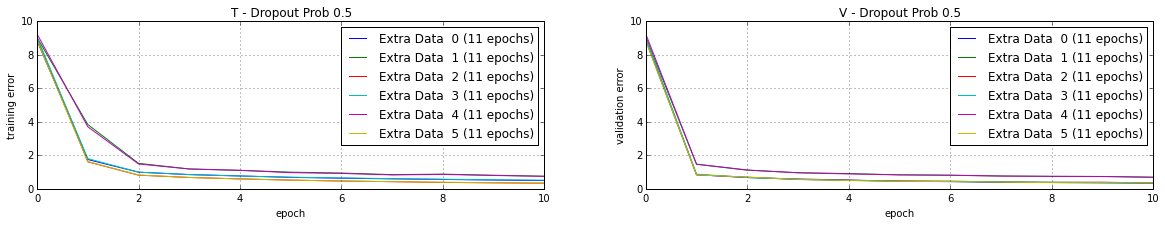

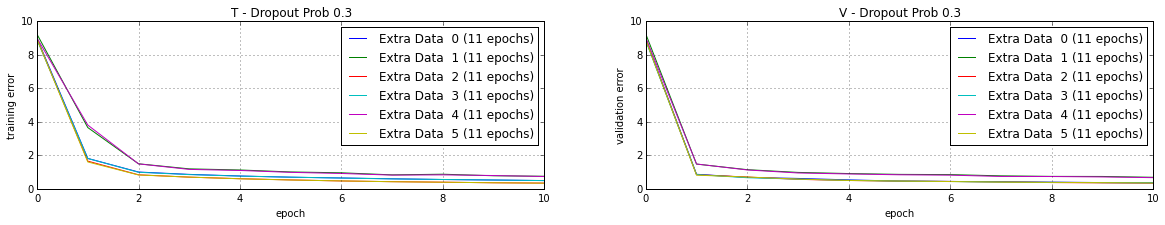

In [16]:
%matplotlib inline
for results in results_list:
    results.draw("Extra Data ", 1, 2, figsize=(20, 3))

### Task 5 - State of the art (5 marks)

Using any techniques you have learnt so far (combining any number of them), build and train the best model you can (no other constraints).

#### THE BEST MODEL
First of all I chose to experiment with deeper model since the cross entropy gave me the best model performace previously. I was able to achieve a high training set accuracy at about 97.8% best the training set was maxed out at 100% meaning it could not be trained further. 

To overcome this I regularised the model with l1, l2 and dropout annealing as well as augmenting the training set with noisy data. This gave me a higher test set accuracy at about 98%.

My next issue was at the final epochs where the accuracy was fluctuating. For this I used an exponential decay for the learning rate scheduler so that the model would only be finely tuned at the final epochs an ovoided stepping over the minimum error.

The final training set accuracy was 98.20%

In [2]:
%matplotlib inline
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# some hyper-parameters
learning_rate = 2.0
max_epochs = 60
pre_max_epochs = 5
cost = CECost()

results = Result("State of the art")
train_dp_aug = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)

logger.warning('Adding noisy examples...')
noise_maker = NoiseMaker(data_set=train_dp, num_batches=500, noise=DropoutNoise(dropout_prob=0.8))
new_batches = noise_maker.make_examples(rng=rng)
add_batches(train_dp_aug, new_batches)
train_dp_aug.reset()
    
# define the model structure
model = MLP(cost=cost)
model.add_layer(Sigmoid(idim=784, odim=311, irange=0.2, rng=rng))
model.add_layer(Sigmoid(idim=311, odim=311, irange=0.2, rng=rng))
model.add_layer(Sigmoid(idim=311, odim=311, irange=0.2, rng=rng))
model.add_layer(Sigmoid(idim=311, odim=311, irange=0.2, rng=rng))
model.add_layer(Sigmoid(idim=311, odim=311, irange=0.2, rng=rng))
model.add_layer(Sigmoid(idim=311, odim=311, irange=0.2, rng=rng))
model.add_layer(Softmax(idim=311, odim=10, rng=rng))

reset_data()
logger.info('Pre Training started...')
start = time.clock()

# pre = AutoEncoder(learning_rate=1.0, max_epochs=1)
pre = CrossEntropy(learning_rate=1.0, max_epochs=pre_max_epochs)
pre.pretrain(model, train_iter=train_dp_aug)
reset_data()

# lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
lr_scheduler = LearningRateExp(learning_rate=learning_rate, max_epochs=max_epochs, rate=16.0)
# lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs)
dp_scheduler = DropoutAnnealing(0.5, 0.5, 0.0125)
optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, dp_scheduler=None,
                         l1_weight=0.001, l2_weight=0.001)

logger.info('Training started...')
train_stats, valid_stats = optimiser.train(model, train_dp_aug, valid_dp)
stop = time.clock()

logger.info('Testing the model on test set...')
tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
logger.warning('MNIST test set accuracy is %.2f %% (cost is %.3f) in %.0f seconds' 
               % (tst_accuracy * 100., tst_cost, stop - start))

results.add_results(train_stats, valid_stats, tst_accuracy)

INFO:root:Pre Training started...
INFO:mlp.optimisers:Epoch 1: Pre-training cost (ce) is 0.488. Accuracy is 87.17%
INFO:mlp.optimisers:Epoch 2: Pre-training cost (ce) is 0.216. Accuracy is 93.64%
INFO:mlp.optimisers:Epoch 3: Pre-training cost (ce) is 0.161. Accuracy is 95.35%
INFO:mlp.optimisers:Epoch 4: Pre-training cost (ce) is 0.128. Accuracy is 96.25%
INFO:mlp.optimisers:Epoch 5: Pre-training cost (ce) is 0.108. Accuracy is 96.83%
INFO:mlp.optimisers:Epoch 1: Pre-training cost (ce) is 0.428. Accuracy is 91.66%
INFO:mlp.optimisers:Epoch 2: Pre-training cost (ce) is 0.116. Accuracy is 96.47%
INFO:mlp.optimisers:Epoch 3: Pre-training cost (ce) is 0.097. Accuracy is 97.05%
INFO:mlp.optimisers:Epoch 4: Pre-training cost (ce) is 0.089. Accuracy is 97.33%
INFO:mlp.optimisers:Epoch 5: Pre-training cost (ce) is 0.082. Accuracy is 97.47%
INFO:mlp.optimisers:Epoch 1: Pre-training cost (ce) is 0.342. Accuracy is 93.00%
INFO:mlp.optimisers:Epoch 2: Pre-training cost (ce) is 0.090. Accuracy is 9

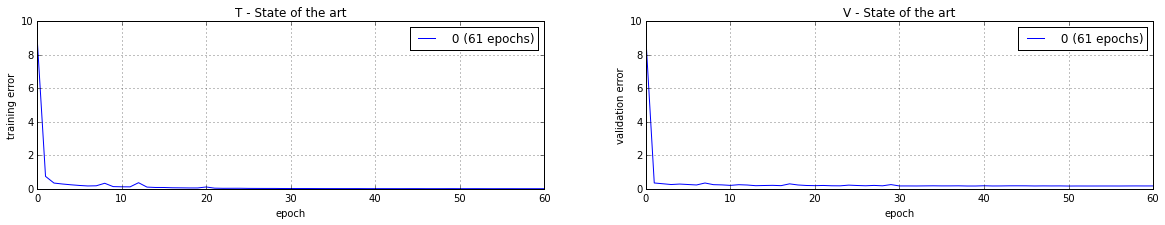

In [3]:
results.draw("", 1, 2, figsize=(20, 3))

# Part 2. Convolutional Neural Networks (55 marks)

In this part of the coursework, you are required to implement deep convolutional networks.  This includes code for forward prop, back prop, and weight updates for convolutional and max-pooling layers, and should support the stacking of convolutional + pooling layers.  You should implement all the parts relating to the convolutional layer in the mlp/conv.py module; if you decide to implement some routines in cython, keep them in mlp/conv.pyx). Attach both files in this notebook.

Implementation tips: Look at [lecture 7](http://www.inf.ed.ac.uk/teaching/courses/mlp/2015/mlp07-cnn.pdf) and [lecture 8](http://www.inf.ed.ac.uk/teaching/courses/mlp/2015/mlp08-cnn2.pdf), and the introductory tutorial, [06_MLP_Coursework2_Introduction.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/06_MLP_Coursework2_Introduction.ipynb)

### Task 6 -  Implement convolutional layer (20 marks)

Implement linear convolutional layer, and then extend to sigmoid and ReLU transfer functions (do it in a similar way to fully-connected layers). Include all relevant code.  It is recommended that you first implement in the naive way with nested loops (python and/or cython);  optionally you may then implement in a vectorised way in numpy.  Include logs for each way you implement the convolutional layer, as timings for different implementations are of interest.  Include all relevant code.

In [2]:
%load -s convolution_fprop_fast,convolution_bprop_fast,convolution_pgrads_fast,ConvLinear,ConvSigmoid,ConvRelu mlp/conv.py

Here is my fully optimised convolution functions.
I have vectorised it with numpy so that calculations are carried out across the entire batch simultaniously
and the written in cython to speed up for loops. In the unit tests there are speed tests which find the numpy/cython implementation to be up to 100X faster. I have included the unit tests as an appendix.

In [ ]:
%load mlp/convx.pyx

### Task 7 - Implement max-pooling layer (10 marks)

Implement a max-pooling layer. Non-overlapping pooling (which was assumed in the lecture presentation) is required. You may also implement a more generic solution with striding as well. Include all relevant code.

In [ ]:
%load -s ConvMaxPool2D mlp/conv.py

### Task 8 - Experiments with convolutional networks (25 marks)

Construct convolutional networks with a softmax output layer and a single fully connected hidden layer. Your first experiments should use one convolutional+pooling layer.  As a default use convolutional kernels of dimension 5x5 (stride 1) and pooling regions of 2x2 (stride 2, hence non-overlapping).

*  Implement and test a convolutional network with 1 feature map
*  Implement and test a convolutional network with 5 feature maps

Explore convolutional networks with two convolutional layers, by implementing, training, and evaluating a network with two convolutional+maxpooling layers with 5 feature maps in the first convolutional layer,  and 10 feature maps in the second convolutional layer.

Carry out further experiments to optimise the convolutional network architecture (you could explore kernel sizes and strides, number of feature maps, sizes and strides of pooling operator, etc. - it is up to you).

In [29]:
train_dp_conv = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)
valid_dp_conv = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=-10, randomize=False)
test_dp_conv = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=-10, randomize=False)

In [3]:
%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.INFO)

# some hyper-parameters
learning_rate = 0.5
max_epochs = 10
cost = CECost()
feature_maps_list = [1, 5]

results = Result("Covolution")

for feature_maps in feature_maps_list:
    # define the model structure
    model = MLP(cost=cost)
    model.add_layer(ConvSigmoid(1, feature_maps, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2))
    model.add_layer(ConvMaxPool2D(num_feat_maps=feature_maps, conv_shape=(24, 24), pool_shape=(2, 2)))
    model.add_layer(Sigmoid(idim=144 * feature_maps, odim=100))
    model.add_layer(Softmax(idim=100, odim=10))

    lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=None,
                             l1_weight=0.0, 
                             l2_weight=0.0)
    train_dp_conv.reset()
    valid_dp_conv.reset()
    test_dp_conv.reset()

    start = time.clock()
    logger.info('Training started...')
    train_stats, valid_stats = optimiser.train(model, train_dp_conv, valid_dp_conv)
    stop = time.clock()

    logger.info('Testing the model on test set...')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp_conv)
    logger.warning('MNIST test set accuracy is %.2f %% (cost is %.3f) in %.0f seconds' 
                   % (tst_accuracy * 100., tst_cost, stop - start))

    results.add_results(train_stats, valid_stats, tst_accuracy)

INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.368. Accuracy is 9.98%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.366. Accuracy is 9.61%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 1.141. Accuracy is 61.79%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.401. Accuracy is 88.64%
INFO:mlp.optimisers:Epoch 1: Took 42 seconds. Training speed 1316 pps. Validation speed 2517 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.396. Accuracy is 87.77%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.301. Accuracy is 90.94%
INFO:mlp.optimisers:Epoch 2: Took 43 seconds. Training speed 1329 pps. Validation speed 2045 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.328. Accuracy is 89.84%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.272. Accuracy is 91.70%
INFO:mlp.optimisers:Epoch 3: Took 42 seconds. Training speed 1318 pps. Validation speed 2498 pps.
INFO:mlp.optimiser

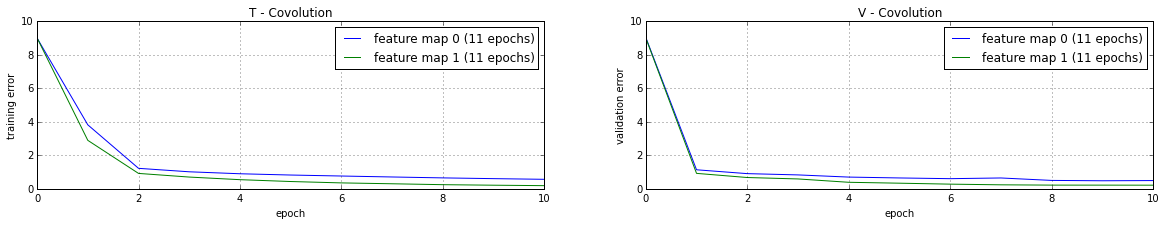

In [5]:
results.draw("feature map", 1, 2, figsize=(20, 3))

#### EXPERIMENT
Explore convolutional networks with two convolutional layers, 
by implementing, training, and evaluating a network with two 
convolutional+maxpooling layers with 5 feature maps in the 
first convolutional layer, and 10 feature maps in the second convolutional layer.

In [17]:
%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.INFO)

# some hyper-parameters
learning_rate = 0.5
max_epochs = 10
cost = CECost()

results = Result("Covolution")

# define the model structure
model = MLP(cost=cost)
model.add_layer(ConvSigmoid(1, 5, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2))
model.add_layer(ConvMaxPool2D(num_feat_maps=5, conv_shape=(24, 24), pool_shape=(2, 2)))
model.add_layer(ConvSigmoid(5, 10, image_shape=(12, 12), kernel_shape=(5, 5), stride=(1, 1), irange=0.2))
model.add_layer(ConvMaxPool2D(num_feat_maps=10, conv_shape=(8, 8), pool_shape=(2, 2)))
model.add_layer(Sigmoid(idim=160, odim=100))
model.add_layer(Softmax(idim=100, odim=10))

lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                         dp_scheduler=None,
                         l1_weight=0.0, 
                         l2_weight=0.0)
train_dp_conv.reset()
valid_dp_conv.reset()
test_dp_conv.reset()

start = time.clock()
logger.info('Training started...')
train_stats, valid_stats = optimiser.train(model, train_dp_conv, valid_dp_conv)
stop = time.clock()

logger.info('Testing the model on test set...')
tst_cost, tst_accuracy = optimiser.validate(model, test_dp_conv)
logger.warning('MNIST test set accuracy is %.2f %% (cost is %.3f) in %.0f seconds' 
               % (tst_accuracy * 100., tst_cost, stop - start))

results.add_results(train_stats, valid_stats, tst_accuracy)

NameError: name 'train_dp_conv' is not defined

In [ ]:
results.draw("", 1, 2, figsize=(20, 3))

#### EXPERIMENT
In this experiemnt I will try to find the optimal number of feature maps for the MNIST data set. This should correspond to the number of meaningful features that can be abstracted from the digits 0 to 9.

In [ ]:
%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.INFO)

# some hyper-parameters
learning_rate = 0.5
max_epochs = 10
cost = CECost()
feature_maps_list = [5, 10, 15, 20]

results = Result("Covolution")

for feature_maps in feature_maps_list:
    # define the model structure
    model = MLP(cost=cost)
    model.add_layer(ConvSigmoid(1, feature_maps, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2))
    model.add_layer(ConvMaxPool2D(num_feat_maps=feature_maps, conv_shape=(24, 24), pool_shape=(2, 2)))
    model.add_layer(Sigmoid(idim=144 * feature_maps, odim=100))
    model.add_layer(Softmax(idim=100, odim=10))

    lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=None,
                             l1_weight=0.0, 
                             l2_weight=0.0)
    train_dp_conv.reset()
    valid_dp_conv.reset()
    test_dp_conv.reset()

    start = time.clock()
    logger.info('Training started...')
    train_stats, valid_stats = optimiser.train(model, train_dp_conv, valid_dp_conv)
    stop = time.clock()

    logger.info('Testing the model on test set...')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp_conv)
    logger.warning('MNIST test set accuracy is %.2f %% (cost is %.3f) in %.0f seconds' 
                   % (tst_accuracy * 100., tst_cost, stop - start))

    results.add_results(train_stats, valid_stats, tst_accuracy)

**This is the end of coursework 2.**

Please remember to save your notebook, and submit your notebook following the instructions at the top.  Please make sure that you have executed all the code cells when you submit the notebook.


### Here are the unit tests

In [ ]:
# %load mlp/tests/test_conv.py
from unittest import TestCase

import numpy
from numpy.testing import assert_array_equal

from mlp.conv import ConvLinear
from mlp.costs import CECost
from mlp.dataset import MNISTDataProvider
from mlp.layers import MLP, Linear, Softmax, Sigmoid
from mlp.optimisers import SGDOptimiser
from mlp.schedulers import LearningRateFixed


class FeatureMapTestCase(TestCase):
    def setUp(self):
        self.rng = numpy.random.RandomState([2015, 10, 10])
        self.rng_state = self.rng.get_state()

    def test_create_linear(self):
        conv = ConvLinear(1, 2, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2)
        weights = conv.W
        self.assertEqual(weights.shape, (1, 2, 5, 5))

    def test_fprop_for_1_iamge(self):
        """ Ensure that 1 forward prop pass works for 1 image """
        conv = ConvLinear(1, 1, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2)
        conv.W = numpy.ones(conv.W.shape, dtype=numpy.float32)

        # make an image of zeros with 1 in 2 corners
        image = numpy.zeros((784), dtype=numpy.float32)
        image[0] = 1.0
        image[783] = 1.0

        # make 1 feature map
        feature_maps = numpy.array([image])

        # make a batch of size 2
        batch = numpy.array([feature_maps])

        num_rows_units = conv.num_rows_units
        num_cols_units = conv.num_cols_units

        expected = numpy.zeros((num_rows_units, num_cols_units), dtype=numpy.float32)
        expected[0][0] = 1.0
        expected[23][23] = 1.0
        actual = conv.fprop(batch)
        assert_array_equal(actual[0][0], expected)

    def test_fprop(self):
        """ Ensure that 1 forward prop pass works """
        conv = ConvLinear(1, 1, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2)
        conv.W = numpy.ones(conv.W.shape, dtype=numpy.float32)

        # make an image of zeros with 1 in 2 corners
        image = numpy.zeros((784), dtype=numpy.float32)
        image[0] = 1.0
        image[783] = 1.0

        # make 1 feature map
        feature_maps = numpy.array([image])

        # make a batch of size 2
        batch = numpy.array([feature_maps, feature_maps])

        num_rows_units = conv.num_rows_units
        num_cols_units = conv.num_cols_units

        expected = numpy.zeros((2, 1, num_rows_units, num_cols_units), dtype=numpy.float32)
        expected[0][0][0][0] = 1.0
        expected[0][0][23][23] = 1.0
        expected[1][0][0][0] = 1.0
        expected[1][0][23][23] = 1.0
        actual = conv.fprop(batch)
        assert_array_equal(actual, expected, verbose=True)

    def test_fprop_from_2d_layer(self):
        """ Ensure that 1 forward prop pass works """
        conv = ConvLinear(1, 1, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2)
        conv.W = numpy.ones(conv.W.shape, dtype=numpy.float32)

        # make an image of zeros with 1 in 2 corners
        image = numpy.zeros((784), dtype=numpy.float32)
        image[0] = 1.0
        image[783] = 1.0

        # make a batch of size 2
        batch = numpy.array([image, image])

        num_rows_units = conv.num_rows_units
        num_cols_units = conv.num_cols_units

        expected = numpy.zeros((2, 1, num_rows_units, num_cols_units), dtype=numpy.float32)
        expected[0][0][0][0] = 1.0
        expected[0][0][23][23] = 1.0
        expected[1][0][0][0] = 1.0
        expected[1][0][23][23] = 1.0
        actual = conv.fprop(batch)
        assert_array_equal(actual, expected, verbose=True)

    def test_fprop_many_out_feature_maps(self):
        """ Ensure that 1 forward prop pass works with many out feature maps """
        conv = ConvLinear(1, 2, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2)
        conv.W = numpy.ones(conv.W.shape, dtype=numpy.float32)

        # make an image of zeros with 1 in 2 corners
        image = numpy.zeros((784), dtype=numpy.float32)
        image[0] = 1.0
        image[783] = 1.0

        # make 2 feature maps
        feature_maps = numpy.array([image])

        # make a batch of size 2
        batch = numpy.array([feature_maps, feature_maps])

        num_rows_units = conv.num_rows_units
        num_cols_units = conv.num_cols_units

        expected = numpy.zeros((2, 2, num_rows_units, num_cols_units), dtype=numpy.float32)
        expected[0][0][0][0] = 1.0
        expected[0][0][23][23] = 1.0
        expected[1][0][0][0] = 1.0
        expected[1][0][23][23] = 1.0
        # copy the previous feature map
        expected[0][1] = expected[0][0]
        expected[1][1] = expected[1][0]
        actual = conv.fprop(batch)
        assert_array_equal(actual, expected, verbose=True)

    def test_fprop_many_inp_feature_maps(self):
        """ Ensure that 1 forward prop pass works with many out feature maps """
        conv = ConvLinear(2, 1, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2)

        conv.W = numpy.ones(conv.W.shape, dtype=numpy.float32)

        # make an image of zeros with 1 in 2 corners
        image = numpy.zeros((784), dtype=numpy.float32)
        image[0] = 1.0
        image[783] = 1.0

        # make 2 feature maps
        feature_maps = numpy.array([image, image])

        # make a batch of size 2
        batch = numpy.array([feature_maps, feature_maps])

        num_rows_units = conv.num_rows_units
        num_cols_units = conv.num_cols_units

        expected = numpy.zeros((2, 1, num_rows_units, num_cols_units), dtype=numpy.float32)
        expected[0][0][0][0] = 2.0
        expected[0][0][23][23] = 2.0
        expected[1][0][0][0] = 2.0
        expected[1][0][23][23] = 2.0
        actual = conv.fprop(batch)
        assert_array_equal(actual, expected, verbose=True)


class ConvLinearTestCase(TestCase):
    def test_model_fprop(self):
        """ Ensure that 1 forward prop pass works """
        cost = CECost()
        model = MLP(cost=cost)
        model.add_layer(ConvLinear(1, 1, image_shape=(28, 28), kernel_shape=(5, 5),stride=(1, 1),irange=0.2))
        model.add_layer(Linear(idim=576, odim=2))

        model.layers[0].W = numpy.ones(model.layers[0].W.shape, dtype=numpy.float32)
        model.layers[1].W = numpy.ones(model.layers[1].W.shape, dtype=numpy.float32)

        # make an image of zeros with 1 in 2 corners
        image = numpy.zeros((784), dtype=numpy.float32)
        image[0] = 1.0
        image[783] = 1.0

        # make 1 feature map
        feature_maps = numpy.array([image])

        # make a batch of size 2
        batch = numpy.array([feature_maps, feature_maps])

        expected = numpy.array([[2., 2.], [2., 2.]])
        actual = model.fprop(batch)
        assert_array_equal(actual, expected, verbose=True)

    def test_model_fprop_multi_feature_maps(self):
        """ Ensure that 1 forward prop pass works """
        cost = CECost()
        model = MLP(cost=cost)
        model.add_layer(ConvLinear(1, 2, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2))
        model.add_layer(Linear(idim=1152, odim=2))

        model.layers[0].W = numpy.ones(model.layers[0].W.shape, dtype=numpy.float32)
        model.layers[1].W = numpy.ones(model.layers[1].W.shape, dtype=numpy.float32)

        # make an image of zeros with 1 in 2 corners
        image = numpy.zeros((784), dtype=numpy.float32)
        image[0] = 1.0
        image[783] = 1.0

        # make 1 feature map
        feature_maps = numpy.array([image])

        # make a batch of size 2
        batch = numpy.array([feature_maps, feature_maps])

        expected = numpy.array([[4., 4.], [4., 4.]])
        actual = model.fprop(batch)
        assert_array_equal(actual, expected, verbose=True)

    def test_model_bprop(self):
        """ Ensure that back prop works with pgrads """
        train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=3, randomize=True)
        valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=3, randomize=True)
        test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=3, randomize=True)
        train_dp.reset()

        cost = CECost()
        model = MLP(cost=cost)
        model.add_layer(ConvLinear(1, 1, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2))
        model.add_layer(Softmax(idim=576, odim=10))

        lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=2)
        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, dp_scheduler=None,
                                 l1_weight=0.0, l2_weight=0.0)

        optimiser.train(model, train_dp, valid_iterator=valid_dp)

        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)

        self.assertAlmostEqual(tst_accuracy, 0.0766, delta=0.005)

    def test_model_bprop_not_first_layer(self):
        """ Ensure that back prop works when the conv layer has 1 below it """
        train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=3, randomize=True)
        valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=3, randomize=True)
        test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=3, randomize=True)
        train_dp.reset()

        cost = CECost()
        model = MLP(cost=cost)
        model.add_layer(Sigmoid(idim=784, odim=784))
        model.add_layer(ConvLinear(1, 1,image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2))
        model.add_layer(Softmax(idim=576, odim=10))

        lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=2)
        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, dp_scheduler=None,
                                 l1_weight=0.0, l2_weight=0.0)

        optimiser.train(model, train_dp, valid_iterator=valid_dp)

        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)

        self.assertAlmostEqual(tst_accuracy, 0.0966, delta=0.005)

    def test_model_bprop_3_feature_maps(self):
        """ Ensure that back prop works when the conv layer has 1 below it """
        train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=1, randomize=True)
        valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=1, randomize=True)
        test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=1, randomize=True)
        train_dp.reset()

        cost = CECost()
        model = MLP(cost=cost)
        model.add_layer(Sigmoid(idim=784, odim=784))
        model.add_layer(ConvLinear(1, 3, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2))
        model.add_layer(Softmax(idim=1728, odim=10))

        lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=2)
        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, dp_scheduler=None, l1_weight=0.0, l2_weight=0.0)

        optimiser.train(model, train_dp, valid_iterator=valid_dp)

        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)

        self.assertAlmostEqual(tst_accuracy, 0.14, delta=0.005)

    def test_model_bprop_3_feature_maps_2_layers(self):
        """ Ensure that back prop works when the conv layer has 1 below it """
        train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=1, randomize=True)
        valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=1, randomize=True)
        test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=1, randomize=True)
        train_dp.reset()

        cost = CECost()
        model = MLP(cost=cost)
        model.add_layer(Sigmoid(idim=784, odim=784))
        model.add_layer(ConvLinear(1, 3, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2))
        model.add_layer(ConvLinear(3, 3, image_shape=(24, 24), kernel_shape=(5, 5), stride=(1, 1), irange=0.2))
        model.add_layer(Softmax(idim=1200, odim=10))

        lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=2)
        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, dp_scheduler=None, l1_weight=0.0, l2_weight=0.0)

        optimiser.train(model, train_dp, valid_iterator=valid_dp)

        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)

        self.assertAlmostEqual(tst_accuracy, 0.12, delta=0.005)







In [ ]:
# %load mlp/tests/test_conv_layers.py
from unittest import TestCase

from mlp.conv import ConvSigmoid, ConvRelu
from mlp.costs import CECost
from mlp.dataset import MNISTDataProvider
from mlp.layers import MLP, Softmax
from mlp.optimisers import SGDOptimiser
from mlp.schedulers import LearningRateFixed


class LayerTypeTestCase(TestCase):
    def test_model_sigmoid(self):
        """ Ensure that back prop works with pgrads """
        train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=3, randomize=True)
        valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=3, randomize=True)
        test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=3, randomize=True)
        train_dp.reset()

        cost = CECost()
        model = MLP(cost=cost)
        model.add_layer(ConvSigmoid(1, 1, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2))
        model.add_layer(Softmax(idim=576, odim=10))

        lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=3)
        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, dp_scheduler=None,
                                 l1_weight=0.0, l2_weight=0.0)

        optimiser.train(model, train_dp, valid_iterator=valid_dp)

        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)

        self.assertAlmostEqual(tst_accuracy, 0.1066, delta=0.005)

    def test_model_relu(self):
        """ Ensure that back prop works with pgrads """
        train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=3, randomize=True)
        valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=3, randomize=True)
        test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=3, randomize=True)
        train_dp.reset()

        cost = CECost()
        model = MLP(cost=cost)
        model.add_layer(ConvRelu(1, 1, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2))
        model.add_layer(Softmax(idim=576, odim=10))

        lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=3)
        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, dp_scheduler=None,
                                 l1_weight=0.0, l2_weight=0.0)

        optimiser.train(model, train_dp, valid_iterator=valid_dp)

        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)

        self.assertAlmostEqual(tst_accuracy, 0.1766, delta=0.005)

In [ ]:
# %load mlp/tests/test_max_pool.py
from unittest import TestCase

from numpy.testing import assert_array_equal, assert_array_almost_equal

from mlp.conv import ConvLinear, ConvMaxPool2D
from mlp.costs import CECost
from mlp.dataset import MNISTDataProvider
from mlp.layers import MLP, Softmax, Sigmoid
from mlp.optimisers import SGDOptimiser
from mlp.schedulers import LearningRateFixed


class MaxPoolTestCase(TestCase):
    def test_model_fprop_max_pool(self):
        """ Ensure that 1 forward prop pass works """
        train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=3, randomize=True)
        train_dp.reset()

        cost = CECost()
        model = MLP(cost=cost)
        model.add_layer(ConvLinear(1, 3, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1),irange=0.2))
        model.add_layer(ConvMaxPool2D(num_feat_maps=3, conv_shape=(24, 24), pool_shape=(2, 2)))
        model.add_layer(Sigmoid(idim=432, odim=4))

        x, t = train_dp.next()
        actual = model.fprop(x)
        assert_array_equal(model.layers[1].sudoW[6][0][7][0], [[0, 0], [0, 1]])
        assert_array_almost_equal(actual[0], [0.471462, 0.463854, 0.356474, 0.594162], verbose=True, decimal=2)

    def test_model_bprop_max_pool(self):
        """ Ensure that back prop works with pgrads """
        train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=3, randomize=True)
        valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=3, randomize=True)
        test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=3, randomize=True)
        train_dp.reset()

        cost = CECost()
        model = MLP(cost=cost)
        model.add_layer(ConvLinear(1, 1, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2))
        model.add_layer(ConvMaxPool2D(num_feat_maps=1, conv_shape=(24, 24), pool_shape=(2, 2)))
        model.add_layer(Sigmoid(idim=144, odim=144))
        model.add_layer(Softmax(idim=144, odim=10))

        lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=2)
        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, dp_scheduler=None,
                                 l1_weight=0.0, l2_weight=0.0)

        optimiser.train(model, train_dp, valid_iterator=valid_dp)

        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)

        self.assertAlmostEqual(tst_accuracy, 0.0766, delta=0.005)

In [ ]:
# %load mlp/tests/test_noise.py
from unittest import TestCase

import numpy

from mlp.dataset import MNISTDataProvider, add_batches
from mlp.noise import DropoutNoise, NoiseMaker


class NoiseTestCase(TestCase):
    def setUp(self):
        self.rng = numpy.random.RandomState([2015, 10, 10])
        self.rng_state = self.rng.get_state()

        self.train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=1, randomize=True)
        self.train_dp.reset()

        noise_type = DropoutNoise(dropout_prob=0.5)
        noise_maker = NoiseMaker(data_set=self.train_dp, num_batches=1, noise=noise_type)
        new_batches = noise_maker.make_examples(rng=self.rng)
        add_batches(self.train_dp, new_batches)

    def test_add_noise(self):

        self.assertEqual(len(self.train_dp.x), 50100)
        self.assertEqual(self.train_dp.t[99], self.train_dp.t[50099])

    def test_can_get_new_examples(self):

        self.assertEqual(len(self.train_dp.x), 50100)
        self.assertEqual(self.train_dp.t[99], self.train_dp.t[50099])


In [ ]:
# %load mlp/tests/test_pre_train.py
from unittest import TestCase

import numpy

from mlp.costs import CECost
from mlp.dataset import MNISTDataProvider
from mlp.layers import Sigmoid, Softmax, MLP
from mlp.optimisers import AutoEncoder, CrossEntropy


class AutoEncoderTestCase(TestCase):
    def test_pretrain(self):
        """ Ensure that  """
        # Given
        train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=1, randomize=True)
        valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=1, randomize=False)

        train_dp.reset()
        valid_dp.reset()

        rng = numpy.random.RandomState([2015, 10, 10])
        rng_state = rng.get_state()

        cost = CECost()
        model = MLP(cost=cost)
        model.add_layer(Sigmoid(idim=784, odim=100, rng=rng))
        model.add_layer(Sigmoid(idim=100, odim=100, rng=rng))
        model.add_layer(Softmax(idim=100, odim=10, rng=rng))
        auto_encoder = AutoEncoder(learning_rate=0.5, max_epochs=5)
        auto_encoder.pretrain(model, train_iter=train_dp)
        self.assertAlmostEqual(model.layers[0].W[0][0], 0.03, delta=0.005)
        self.assertAlmostEqual(model.layers[1].W[0][0], -0.03, delta=0.005)
        self.assertAlmostEqual(model.layers[2].W[0][0], 0.097, delta=0.005)


class CrossEntropyTestCase(TestCase):
    def test_pretrain(self):
        """ Ensure that """
        # Given
        train_dp = MNISTDataProvider(dset='train', batch_size=88, max_num_batches=1, randomize=True)
        valid_dp = MNISTDataProvider(dset='valid', batch_size=88, max_num_batches=1, randomize=False)

        train_dp.reset()
        valid_dp.reset()

        rng = numpy.random.RandomState([2015, 10, 10])
        rng_state = rng.get_state()

        cost = CECost()
        model = MLP(cost=cost)
        model.add_layer(Sigmoid(idim=784, odim=100, rng=rng))
        model.add_layer(Sigmoid(idim=100, odim=100, rng=rng))
        model.add_layer(Sigmoid(idim=100, odim=100, rng=rng))
        model.add_layer(Softmax(idim=100, odim=10, rng=rng))
        auto_encoder = CrossEntropy(learning_rate=0.5, max_epochs=5)
        auto_encoder.pretrain(model, train_iter=train_dp)
        self.assertAlmostEqual(model.layers[0].W[0][0], 0.03, delta=0.005)
        self.assertAlmostEqual(model.layers[1].W[0][0], -0.011, delta=0.05)
        self.assertAlmostEqual(model.layers[2].W[0][0], 0.097, delta=0.005)


In [ ]:
# %load mlp/tests/test_speed.py
import time
from unittest import TestCase

from mlp.conv import ConvLinear, ConvMaxPool2D
from mlp.costs import CECost
from mlp.dataset import MNISTDataProvider
from mlp.layers import MLP, Softmax, Sigmoid


class ConvSpeedTestCase(TestCase):
    def test_model_fprop_fast(self):
        """ Ensure that back prop works when the conv layer has 1 below it """
        train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=10, randomize=True)
        train_dp.reset()

        cost = CECost()
        model = MLP(cost=cost)
        model.add_layer(Sigmoid(idim=784, odim=784))
        model.add_layer(ConvLinear(1, 3, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2))
        model.add_layer(ConvLinear(3, 3, image_shape=(24, 24), kernel_shape=(5, 5), stride=(1, 1), irange=0.2))
        model.add_layer(Softmax(idim=1200, odim=10))

        for x, t in train_dp:
            start = time.clock()
            y = model.fprop(x)
            stop = time.clock()
            print("batch done in {}".format(stop - start))
        self.assertTrue(True)

    def test_model_bprop_fast(self):
        """ Ensure that back prop works when the conv layer has 1 below it """
        train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=10, randomize=True)
        train_dp.reset()

        cost = CECost()
        model = MLP(cost=cost)
        model.add_layer(ConvLinear(1, 3, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1), irange=0.2))
        model.add_layer(ConvMaxPool2D(num_feat_maps=3, conv_shape=(24, 24), pool_shape=(2, 2)))
        model.add_layer(Sigmoid(idim=432, odim=432))
        model.add_layer(Softmax(idim=432, odim=10))

        for x, t in train_dp:
            full_start = time.clock()
            start = time.clock()
            y = model.fprop(x)
            stop = time.clock()
            print("batch fprop done in {}".format(stop - start))
            # compute the cost and grad of the cost w.r.t y
            cost = model.cost.cost(y, t)
            cost_grad = model.cost.grad(y, t)
            # do backward pass through the model
            start = time.clock()
            model.bprop(cost_grad)
            stop = time.clock()
            print("batch bprop done in {}".format(stop - start))

            print("batch done in {}".format(stop - full_start))
        self.assertTrue(True)

In [ ]:
# %load mlp/tests/test_utils.py
from unittest import TestCase

import numpy

from mlp.conv import ConvLinear


class UtilsTestCase(TestCase):
    def test_conv_linear_fprop(self):
        conv = ConvLinear(1, 2, image_shape=(4, 4), kernel_shape=(2, 2), stride=(1, 1), irange=0.2)
        out = self.conv_linear_fprop(conv)
        self.assertTrue(out)

    def conv_linear_fprop(self, layer, kernel_order='ioxy', kernels_first=True,
                          dtype=numpy.float):
        """
        Tests forward propagation method of a convolutional layer.

        Checks the outputs of `fprop` method for a fixed input against known
        reference values for the outputs and raises an AssertionError if
        the outputted values are not consistent with the reference values. If
        tests are all passed returns True.

        Parameters
        ----------
        layer : instance of Layer subclass
            Convolutional (linear only) layer implementation. It must implement
            the methods `get_params`, `set_params` and `fprop`.
        kernel_order : string
            Specifes dimension ordering assumed for convolutional kernels
            passed to `layer`. Default is `ioxy` which corresponds to:
                input channels, output channels, image x, image y
            The other option is 'oixy' which corresponds to
                output channels, input channels, image x, image y
            Any other value will raise a ValueError exception.
        kernels_first : boolean
            Specifies order in which parameters are passed to and returned from
            `get_params` and `set_params`. Default is True which corresponds
            to signatures of `get_params` and `set_params` being:
                kernels, biases = layer.get_params()
                layer.set_params([kernels, biases])
            If False this corresponds to signatures of `get_params` and
            `set_params` being:
                biases, kernels = layer.get_params()
                layer.set_params([biases, kernels])
        dtype : numpy data type
             Data type to use in numpy arrays passed to layer methods. Default
             is `numpy.float`.

        Raises
        ------
        AssertionError
            Raised if output of `layer.fprop` is inconsistent with reference
            values either in shape or values.
        ValueError
            Raised if `kernel_order` is not a valid order string.
        """
        inputs = numpy.arange(96).reshape((2, 3, 4, 4)).astype(dtype)
        kernels = numpy.arange(-12, 12).reshape((3, 2, 2, 2)).astype(dtype)
        if kernel_order == 'oixy':
            kernels = kernels.swapaxes(0, 1)
        elif kernel_order != 'ioxy':
            raise ValueError('kernel_order must be one of "ioxy" and "oixy"')
        biases = numpy.arange(2).astype(dtype)
        true_output = numpy.array(
                [[[[496., 466., 436.],
                   [376., 346., 316.],
                   [256., 226., 196.]],
                  [[1385., 1403., 1421.],
                   [1457., 1475., 1493.],
                   [1529., 1547., 1565.]]],
                 [[[-944., -974., -1004.],
                   [-1064., -1094., -1124.],
                   [-1184., -1214., -1244.]],
                  [[2249., 2267., 2285.],
                   [2321., 2339., 2357.],
                   [2393., 2411., 2429.]]]], dtype=dtype)
        try:
            orig_params = layer.get_params()
            if kernels_first:
                layer.set_params([kernels, biases])
            else:
                layer.set_params([biases, kernels])
            layer_output = layer.fprop(inputs)
            layer_output.reshape(true_output.shape)
            assert layer_output.shape == true_output.shape, (
                'Layer fprop gives incorrect shaped output. '
                'Correct shape is {0} but returned shape is {1}.'
                    .format(true_output.shape, layer_output.shape)
            )
            assert numpy.allclose(layer_output, true_output), (
                'Layer fprop does not give correct output. '
                'Correct output is {0}\n but returned output is {1}.'
                    .format(true_output, layer_output)
            )
        finally:
            layer.set_params(orig_params)
        return True

    def test_conv_linear_bprop(self):
        conv = ConvLinear(3, 2, image_shape=(4, 4), kernel_shape=(2, 2), stride=(1, 1), irange=0.2)
        out = self.conv_linear_bprop(conv)
        self.assertTrue(out)

    def conv_linear_bprop(self, layer, kernel_order='ioxy', kernels_first=True,
                          dtype=numpy.float):
        """
        Tests input gradients backpropagation method of a convolutional layer.

        Checks the outputs of `bprop` method for a fixed input against known
        reference values for the outputs and raises an AssertionError if
        the outputted values are not consistent with the reference values. If
        tests are all passed returns True.

        Parameters
        ----------
        layer : instance of Layer subclass
            Convolutional (linear only) layer implementation. It must implement
            the methods `get_params`, `set_params` and `bprop`.
        kernel_order : string
            Specifes dimension ordering assumed for convolutional kernels
            passed to `layer`. Default is `ioxy` which corresponds to:
                input channels, output channels, image x, image y
            The other option is 'oixy' which corresponds to
                output channels, input channels, image x, image y
            Any other value will raise a ValueError exception.
        kernels_first : boolean
            Specifies order in which parameters are passed to and returned from
            `get_params` and `set_params`. Default is True which corresponds
            to signatures of `get_params` and `set_params` being:
                kernels, biases = layer.get_params()
                layer.set_params([kernels, biases])
            If False this corresponds to signatures of `get_params` and
            `set_params` being:
                biases, kernels = layer.get_params()
                layer.set_params([biases, kernels])
        dtype : numpy data type
             Data type to use in numpy arrays passed to layer methods. Default
             is `numpy.float`.

        Raises
        ------
        AssertionError
            Raised if output of `layer.bprop` is inconsistent with reference
            values either in shape or values.
        ValueError
            Raised if `kernel_order` is not a valid order string.
        """
        inputs = numpy.arange(96).reshape((2, 3, 4, 4)).astype(dtype)
        kernels = numpy.arange(-12, 12).reshape((3, 2, 2, 2)).astype(dtype)
        if kernel_order == 'oixy':
            kernels = kernels.swapaxes(0, 1)
        elif kernel_order != 'ioxy':
            raise ValueError('kernel_order must be one of "ioxy" and "oixy"')
        biases = numpy.arange(2).astype(dtype)
        igrads = numpy.arange(-20, 16).reshape((2, 2, 3, 3)).astype(dtype)
        true_ograds = numpy.array(
                [[[[328., 605., 567., 261.],
                   [534., 976., 908., 414.],
                   [426., 772., 704., 318.],
                   [170., 305., 275., 123.]],
                  [[80., 125., 119., 45.],
                   [86., 112., 108., 30.],
                   [74., 100., 96., 30.],
                   [18., 17., 19., 3.]],
                  [[-168., -355., -329., -171.],
                   [-362., -752., -692., -354.],
                   [-278., -572., -512., -258.],
                   [-134., -271., -237., -117.]]],
                 [[[-32., -79., -117., -63.],
                   [-114., -248., -316., -162.],
                   [-222., -452., -520., -258.],
                   [-118., -235., -265., -129.]],
                  [[8., 17., 11., 9.],
                   [14., 40., 36., 30.],
                   [2., 28., 24., 30.],
                   [18., 53., 55., 39.]],
                  [[48., 113., 139., 81.],
                   [142., 328., 388., 222.],
                   [226., 508., 568., 318.],
                   [154., 341., 375., 207.]]]], dtype=dtype)
        try:
            orig_params = layer.get_params()
            if kernels_first:
                layer.set_params([kernels, biases])
            else:
                layer.set_params([biases, kernels])
            layer_deltas, layer_ograds = layer.bprop(None, igrads)
            assert layer_deltas.shape == igrads.shape, (
                'Layer bprop give incorrectly shaped deltas output.'
                'Correct shape is {0} but returned shape is {1}.'
                    .format(igrads.shape, layer_deltas.shape)
            )
            assert numpy.allclose(layer_deltas, igrads), (
                'Layer bprop does not give correct deltas output. '
                'Correct output is {0}\n but returned output is {1}.'
                    .format(igrads, layer_deltas)
            )
            layer_ograds = layer_ograds.reshape(true_ograds.shape)
            assert layer_ograds.shape == true_ograds.shape, (
                'Layer bprop gives incorrect shaped ograds output. '
                'Correct shape is {0} but returned shape is {1}.'
                    .format(true_ograds.shape, layer_ograds.shape)
            )
            assert numpy.allclose(layer_ograds, true_ograds), (
                'Layer bprop does not give correct ograds output. '
                'Correct output is {0}\n but returned output is {1}.'
                    .format(true_ograds, layer_ograds)
            )
        finally:
            layer.set_params(orig_params)
        return True

    def test_conv_linear_pgrads(self):
        conv = ConvLinear(3, 2, image_shape=(4, 4), kernel_shape=(2, 2), stride=(1, 1), irange=0.2)
        out = self.conv_linear_pgrads(conv)
        self.assertTrue(out)

    def conv_linear_pgrads(self, layer, kernel_order='ioxy', kernels_first=True,
                           dtype=numpy.float):
        """
        Tests parameter gradients backpropagation method of a convolutional layer.

        Checks the outputs of `pgrads` method for a fixed input against known
        reference values for the outputs and raises an AssertionError if
        the outputted values are not consistent with the reference values. If
        tests are all passed returns True.

        Parameters
        ----------
        layer : instance of Layer subclass
            Convolutional (linear only) layer implementation. It must implement
            the methods `get_params`, `set_params` and `pgrads`.
        kernel_order : string
            Specifes dimension ordering assumed for convolutional kernels
            passed to `layer`. Default is `ioxy` which corresponds to:
                input channels, output channels, image x, image y
            The other option is 'oixy' which corresponds to
                output channels, input channels, image x, image y
            Any other value will raise a ValueError exception.
        kernels_first : boolean
            Specifies order in which parameters are passed to and returned from
            `get_params` and `set_params`. Default is True which corresponds
            to signatures of `get_params` and `set_params` being:
                kernels, biases = layer.get_params()
                layer.set_params([kernels, biases])
            If False this corresponds to signatures of `get_params` and
            `set_params` being:
                biases, kernels = layer.get_params()
                layer.set_params([biases, kernels])
        dtype : numpy data type
             Data type to use in numpy arrays passed to layer methods. Default
             is `numpy.float`.

        Raises
        ------
        AssertionError
            Raised if output of `layer.pgrads` is inconsistent with reference
            values either in shape or values.
        ValueError
            Raised if `kernel_order` is not a valid order string.
        """
        inputs = numpy.arange(96).reshape((2, 3, 4, 4)).astype(dtype)
        kernels = numpy.arange(-12, 12).reshape((3, 2, 2, 2)).astype(dtype)
        biases = numpy.arange(2).astype(dtype)
        deltas = numpy.arange(-20, 16).reshape((2, 2, 3, 3)).astype(dtype)
        true_kernel_grads = numpy.array(
                [[[[390., 264.],
                   [-114., -240.]],
                  [[5088., 5124.],
                   [5232., 5268.]]],
                 [[[-1626., -1752.],
                   [-2130., -2256.]],
                  [[5664., 5700.],
                   [5808., 5844.]]],
                 [[[-3642., -3768.],
                   [-4146., -4272.]],
                  [[6240., 6276.],
                   [6384., 6420.]]]], dtype=dtype)
        if kernel_order == 'oixy':
            kernels = kernels.swapaxes(0, 1)
            true_kernel_grads = true_kernel_grads.swapaxes(0, 1)
        elif kernel_order != 'ioxy':
            raise ValueError('kernel_order must be one of "ioxy" and "oixy"')
        true_bias_grads = numpy.array([-126., 36.], dtype=dtype)
        try:
            orig_params = layer.get_params()
            if kernels_first:
                layer.set_params([kernels, biases])
            else:
                layer.set_params([biases, kernels])
            layer_kernel_grads, layer_bias_grads = layer.pgrads(inputs, deltas)
            assert layer_kernel_grads.shape == true_kernel_grads.shape, (
                'Layer pgrads gives incorrect shaped kernel gradients output. '
                'Correct shape is {0} but returned shape is {1}.'
                    .format(true_kernel_grads.shape, layer_kernel_grads.shape)
            )
            assert numpy.allclose(layer_kernel_grads, true_kernel_grads), (
                'Layer pgrads does not give correct kernel gradients output. '
                'Correct output is {0}\n but returned output is {1}.'
                    .format(true_kernel_grads, layer_kernel_grads)
            )
            assert layer_bias_grads.shape == true_bias_grads.shape, (
                'Layer pgrads gives incorrect shaped bias gradients output. '
                'Correct shape is {0} but returned shape is {1}.'
                    .format(true_bias_grads.shape, layer_bias_grads.shape)
            )
            assert numpy.allclose(layer_bias_grads, true_bias_grads), (
                'Layer pgrads does not give correct bias gradients output. '
                'Correct output is {0}\n but returned output is {1}.'
                    .format(true_bias_grads, layer_bias_grads)
            )
        finally:
            layer.set_params(orig_params)
        return True
